# Notebook
https://www.kaggle.com/williamroe/bi-lstm-with-crf-for-ner

In [1]:
%pip install tensorflow==2.4.0  # 2.5.0  # 2.2.0

     |████████████████████████████████| 394.7 MB 3.7 kB/s  eta 0:00:01     |███████████████▍                | 189.1 MB 42.9 MB/s eta 0:00:05
     |████████████████████████████████| 132 kB 50.3 MB/s eta 0:00:01
     |████████████████████████████████| 42 kB 323 kB/s  eta 0:00:01
     |████████████████████████████████| 2.9 MB 16.2 MB/s eta 0:00:01
     |████████████████████████████████| 65 kB 3.9 MB/s  eta 0:00:01
     |████████████████████████████████| 3.8 MB 12.8 MB/s eta 0:00:01
     |████████████████████████████████| 462 kB 17.5 MB/s eta 0:00:01
     |████████████████████████████████| 6.0 MB 66.0 MB/s eta 0:00:01     |█████████▎                      | 1.7 MB 66.0 MB/s eta 0:00:01
     |████████████████████████████████| 147 kB 19.5 MB/s eta 0:00:01
     |████████████████████████████████| 781 kB 60.4 MB/s eta 0:00:01
     |████████████████████████████████| 97 kB 9.6 MB/s  eta 0:00:01
     |████████████████████████████████| 4.9 MB 63.2 MB/s eta 0:00:01
     |█████████████████████████████

In [2]:
# %pip install tensorflow_addons==0.13.0

In [3]:
# %pip install keras-crf==0.2.0

In [4]:
# %pip install tensorflow-cpu==2.4.0

In [5]:
# %pip install git+https://www.github.com/keras-team/keras-contrib.git
# # %pip install keras-contrib==0.1

In [6]:
# https://github.com/xuxingya/tf2crf
# %pip install tf2crf==0.1.32

In [7]:
# %env SM_FRAMEWORK=tf.keras

In [8]:
# %pip uninstall --yes tf-nightly

In [9]:
%pip install s3fs

Note: you may need to restart the kernel to use updated packages.


In [1]:
import numpy as np
import pandas as pd 
import s3fs

filepath = 's3://sagemaker-studio-528576943967-ssf9zkrg3os/polnear-conll/prepared/'

In [2]:
train_filename = 'polnear_preprocessed_train_noBIO.tsv'
df_train = pd.read_csv(filepath + train_filename, sep="\t")

In [3]:
print(len(df_train.index))
df_train.head(20)

727161


,Unnamed: 0,sentence_idx,word,tag
0,0,1,Mark,SOURCE
1,1,1,Cuban,SOURCE
2,2,1,:,CUE
3,3,1,I,CONTENT
4,4,1,would,CONTENT
5,5,1,consider,CONTENT
6,6,1,a,CONTENT
7,7,1,future,CONTENT
8,8,1,White,CONTENT
9,9,1,House,CONTENT


In [4]:
test_filename = 'polnear_preprocessed_test_noBIO.tsv'
df_test = pd.read_csv(filepath + test_filename, sep="\t")

In [5]:
print(len(df_test.index))
df_test.head(20)

73370


,Unnamed: 0,sentence_idx,word,tag
0,0,1,Hillary,O
1,1,1,Clinton,O
2,2,1,drops,O
3,3,1,Into,O
4,4,1,Detroit,O
5,5,1,as,O
6,6,1,Democrats,SOURCE
7,7,1,get,CUE
8,8,1,nervous,CUE
9,9,1,about,CUE


In [6]:
# import numpy as np
# import pandas as pd 
# import s3fs
# from os import listdir
# from os.path import isfile, join

# files_list = listdir(filepath)
# # files_list = ['wsj_0003.xml.conll.features.foreval']

# df_train = pd.DataFrame()
# for filename in files_list[0:100]:
#     df = pd.read_csv(filepath + filename, sep="\t", header=None, engine='python', names=['col' + str(x) for x in range(1, 30) ])
#     # Delete all columns fully filled with NaN
#     df = df.dropna(axis=1, how='all')
#     df_train = df_train.append(df)
    
# print(len(df_train.index))
# # print(sorted(files_list))

In [7]:
class SentenceGetter(object):
    
    def __init__(self, dataset):
        self.n_sent = 1
        self.dataset = dataset
        self.empty = False
        agg_func = lambda s: [(w, t) for w,t in zip(s["word"].values.tolist(),
                                                        s["tag"].values.tolist())]
        self.grouped = self.dataset.groupby("sentence_idx").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [8]:
getter_train = SentenceGetter(df_train)
getter_test = SentenceGetter(df_test)

In [9]:
sentences_train = getter_train.sentences
sentences_test = getter_test.sentences

In [10]:
# print(sentences_train[1])

In [11]:
# print(sentences_train[10])

In [12]:
# print(sentences_test[10])

In [13]:
maxlen = max([len(s) for s in sentences_train])
print ('Maximum sequence length:', maxlen)

Maximum sequence length: 24226


In [14]:
# Check how long sentences are so that we can pad them
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot")

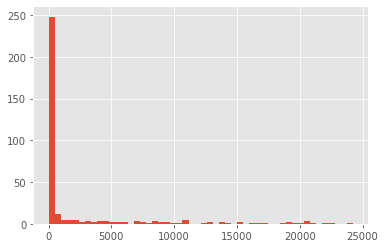

In [15]:
plt.hist([len(s) for s in sentences_train], bins=50)
plt.show()

In [16]:
words_train = list(set(df_train["word"].values))
words_train.append("ENDPAD")

In [17]:
words_test = list(set(df_test["word"].values))
words_test.append("ENDPAD")

In [18]:
n_words = len(words_train)
n_words

24436

In [19]:
from math import nan

tags = []
for tag in set(df_train["tag"].values):
    if tag is nan or isinstance(tag, float):
        tags.append('unk')
    else:
        tags.append(tag)
print(tags)

['CONTENT', 'SOURCE', 'CUE', 'O']


In [20]:
n_tags = len(tags); n_tags

4

In [21]:
from future.utils import iteritems
word2idx_train = {w: i for i, w in enumerate(words_train)}
word2idx_test = {w: i for i, w in enumerate(words_test)}

tag2idx = {t: i for i, t in enumerate(tags)}
idx2tag = {v: k for k, v in iteritems(tag2idx)}

In [25]:
word2idx_train['the']

9444

In [26]:
# word2idx

In [27]:
tag2idx["O"]

3

In [28]:
print(tag2idx)

{'CONTENT': 0, 'SOURCE': 1, 'CUE': 2, 'O': 3}


In [29]:
idx2tag[3]

'O'

In [30]:
idx2tag

{0: 'CONTENT', 1: 'SOURCE', 2: 'CUE', 3: 'O'}

In [31]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

X_train = [[word2idx_train[w[0]] for w in s] for s in sentences_train]
X_test = [[word2idx_test[w[0]] for w in s] for s in sentences_test]

In [32]:
print(X_train[10])

[23319, 13373, 2160, 15985, 23709, 9444, 230, 12264, 23495, 3795, 2122, 9519, 17524, 13418, 8497, 12155, 4822, 20807, 7192, 1816, 12120, 11016, 190, 8497, 8735, 23709, 17534, 194, 8560, 730, 2122, 985, 6393, 1225, 8560, 11150, 10396, 14067, 23709, 16365, 8497, 4487, 12411, 8497, 2261, 12155, 24166, 15975, 24386, 19166, 6671, 10084, 19517, 5762, 23319, 22927, 23615, 14540, 9519, 6393, 19166, 19540, 3968, 23495, 12155, 14, 18760, 13373, 3724, 7928, 12155, 22823, 5758, 8497, 9444, 19580, 24120, 675, 15975, 9444, 19473, 11142, 21036, 11693, 3489, 12660, 1491, 8497, 5844, 9444, 16402, 18503, 2168, 13373, 5844, 12155, 17857, 18680, 6965, 2122, 1491, 12704, 15975, 22746, 9444, 2570, 19166, 3974, 6393, 7813, 2122, 15552, 23709, 20926, 14000, 23495, 12155, 13945, 23709, 5578, 12155, 19851, 8497, 6241, 9444, 230, 2570, 2122, 9444, 17905, 1816, 23658, 1491, 20253, 16995, 1218, 9444, 24021, 11016, 11442, 9879, 9444, 13212, 1816, 280, 6480, 13945, 11296, 5903, 20766, 22746, 22310, 21846, 14441, 133

In [33]:
np.array(X_train).shape

(335,)

In [34]:
X_train = pad_sequences(maxlen=maxlen, sequences=X_train, padding="post",value=n_words - 1)
print(X_train[10])

[23319 13373  2160 ... 24435 24435 24435]


In [35]:
X_test = pad_sequences(maxlen=maxlen, sequences=X_test, padding="post",value=n_words - 1)
print(X_test[10])

[ 5759  5045   284 ... 24435 24435 24435]


In [36]:
y_idx_train = [[tag2idx[w[1]] for w in s] for s in sentences_train]
print('sentences_train[25]')
print(sentences_train[25])
print('y_idx_train[25]')
print(y_idx_train[25])
print('sentences_train[10]')
print(sentences_train[10])
print('y_idx_train[10]')
print(y_idx_train[10])
print(len(y_idx_train[10]))

sentences_train[25]
[('in', 'O'), ('he', 'O'), ('2014', 'O'), ('interview', 'O'), (',', 'O'), ('Lazar', 'SOURCE'), ('tell', 'CUE'), ('FBI', 'O'), ('agent', 'O'), ('that', 'CONTENT'), ('he', 'CONTENT'), ('trawl', 'CONTENT'), ('more', 'CONTENT'), ('or', 'CONTENT'), ('less', 'CONTENT'), ('randomly', 'CONTENT'), ('through', 'CONTENT'), ('the', 'CONTENT'), ('online', 'CONTENT'), ('account', 'CONTENT'), ('of', 'CONTENT'), ('``', 'CONTENT'), ('important', 'CONTENT'), ('people', 'CONTENT'), (',', 'CONTENT'), ("''", 'CONTENT'), ('look', 'CONTENT'), ('for', 'CONTENT'), ('weak', 'CONTENT'), ('spot', 'CONTENT'), ('.', 'O'), ('so', 'O'), (',', 'O'), ('if', 'O'), ('this', 'O'), ('be', 'O'), ('all', 'O'), ('about', 'O'), ('Sanders', 'O'), ("'s", 'O'), ('hurt', 'O'), ('feeling', 'O'), (',', 'O'), ('let', 'O'), ('we', 'SOURCE'), ('praise', 'CUE'), ('and', 'CUE'), ('affirm', 'CUE'), ('he', 'CONTENT'), ('.', 'O'), ('the', 'CONTENT'), ('entire', 'CONTENT'), ('GOP', 'CONTENT'), ('field', 'CONTENT'), ('bene

In [37]:
y_idx_test = [[tag2idx[w[1]] for w in s] for s in sentences_test]
print('sentences_test[25]')
print(sentences_test[25])
print('y_idx_test[25]')
print(y_idx_test[25])
print('sentences_test[10]')
print(sentences_test[10])
print('y_idx_test[10]')
print(y_idx_test[10])
print(len(y_idx_test[10]))

sentences_test[25]
[('in', 'O'), ('that', 'O'), ('inquiry', 'O'), (',', 'O'), ('the', 'O'), ('F.B.I.', 'O'), ('this', 'O'), ('month', 'O'), ('seize', 'O'), ('a', 'O'), ('laptop', 'O'), ('that', 'O'), ('contain', 'O'), ('thousand', 'O'), ('of', 'O'), ('message', 'O'), ('belong', 'O'), ('to', 'O'), ('Ms.', 'O'), ('Abedin', 'O'), (',', 'O'), ('a', 'O'), ('top', 'O'), ('aide', 'O'), ('to', 'O'), ('Mrs.', 'O'), ('Clinton', 'O'), ('.', 'O'), ('Mike', 'O'), ('LeeRep', 'O'), ('.', 'O'), ('many', 'CONTENT'), ('of', 'CONTENT'), ('these', 'CONTENT'), ('attack', 'CONTENT'), ('can', 'CONTENT'), ('be', 'CONTENT'), ('trace', 'CONTENT'), ('to', 'CONTENT'), ('U.S.', 'CONTENT'), ('territory', 'CONTENT'), ('.', 'CONTENT'), ('in', 'O'), ('2008', 'O'), (',', 'O'), ('when', 'O'), ('the', 'O'), ('question', 'O'), ('of', 'O'), ('likability', 'O'), ('come', 'O'), ('up', 'O'), ('in', 'O'), ('the', 'O'), ('democratic', 'O'), ('primary', 'O'), (',', 'O'), ('Illinois', 'SOURCE'), ('Sen.', 'SOURCE'), ('Barack', 'SO

In [38]:
y_train = pad_sequences(maxlen=maxlen, sequences=y_idx_train, padding="post", value=tag2idx["O"])
print(y_train[10])
print(len(y_train[10]))

[0 0 0 ... 3 3 3]
24226


In [39]:
y_test = pad_sequences(maxlen=maxlen, sequences=y_idx_test, padding="post", value=tag2idx["O"])
print(y_test[10])
print(len(y_test[10]))

[3 3 3 ... 3 3 3]
24226


In [40]:
from tensorflow.keras.utils import to_categorical
y_train = [to_categorical(i, num_classes=n_tags) for i in y_train]
print(y_train[10][0])

[1. 0. 0. 0.]


In [41]:
y_test = [to_categorical(i, num_classes=n_tags) for i in y_test]
print(y_test[10][0])

[0. 0. 0. 1.]


In [42]:
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

# X_train, y_train = X, y
# X_test, y_test = X, y

In [43]:
print(X_train[10][0])
print(X_test[10][0])
print(y_train[10][0])
print(y_test[10][0])

23319
5759
[1. 0. 0. 0.]
[0. 0. 0. 1.]


In [44]:
from tensorflow.keras.models import Model, Sequential  # , Input
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
import tensorflow.keras as k
import tensorflow as tf

In [45]:
print(k.__version__)

2.3.0-tf


In [46]:
# import tensorflow.keras.utils as generic_utils
# from keras_contrib.layers.crf import CRF
# AttributeError: module 'tensorflow.compat.v2' has no attribute '__internal__'

In [47]:
word_embedding_size = 300

https://github.com/xuxingya/tf2crf

More inspiration:
https://github.com/Akshayc1/named-entity-recognition/blob/master/NER%20using%20Bidirectional%20LSTM%20-%20CRF%20.ipynb
https://www.kaggle.com/nikkisharma536/ner-with-bilstm-and-crf

In [48]:
# Kaggle example code 

inputs = Input(shape=(maxlen,))
# https://stackoverflow.com/questions/55770009/how-to-use-a-pre-trained-embedding-matrix-in-tensorflow-2-0-rnn-as-initial-weigh
outputs = Embedding(input_dim=n_words, output_dim=word_embedding_size, input_length=maxlen)(inputs)
outputs = Bidirectional(LSTM(units=word_embedding_size, 
                             return_sequences=True, 
                             dropout=0.5, 
                             recurrent_dropout=0.5, 
                             kernel_initializer=k.initializers.he_normal()))(outputs)
outputs = LSTM(units=word_embedding_size * 2, 
               return_sequences=True, 
               dropout=0.5, 
               recurrent_dropout=0.5, 
               kernel_initializer=k.initializers.he_normal())(outputs)
# https://github.com/xuxingya/tf2crf: Add internal kernel like CRF in keras_contrib, so now there is no need to stack a Dense layer before the CRF layer.
outputs = Dense(n_tags, activation="relu")(outputs)  # previously softmax output layer
# outputs = TimeDistributed(Dense(n_tags, activation="relu"))(outputs)  # previously softmax output layer
# outputs = TimeDistributed(Dense(n_tags, activation=tensorflow.keras.activations.softmax))(outputs)  # previously softmax output layer

# crf = CRF(n_tags)  # CRF layer
# out = crf(outputs)  # output
# model = Model(input, out)

adam = k.optimizers.Adam(lr=0.0005, beta_1=0.9, beta_2=0.999)


In [49]:
# Kaggle version (removed CRF code)

model = Model(inputs, outputs)

# https://stackoverflow.com/questions/61742556/valueerror-shapes-none-1-and-none-2-are-incompatible
# model.compile(optimizer='adam', loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model.compile(optimizer=adam, loss="categorical_crossentropy", metrics=["accuracy"])
# model.compile(optimizer=adam, loss=crf.loss_function, metrics=[crf.accuracy, 'accuracy'])# Saving the best only

In [50]:
# # Saving the best only
# from tensorflow.keras.callbacks import ModelCheckpoint

# filepath="ner-bi-lstm-td-model-{val_accuracy:.2f}.hdf5"
# checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
# callbacks_list = [checkpoint]

In [51]:
# # tfcrf version
# model.fit(x=X_train, y=np.array(y_train), epochs=1, batch_size=2)
# model.save('tests/1')

In [52]:
# # Generate generalization metrics
# i = len(X_test) - 1 
# score = model.evaluate(np.array([X_test[:i]]), y_test, verbose=0)
# print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

In [53]:
model.fit(X_train, np.array(y_train), batch_size=256, epochs=20, validation_split=0.1, verbose=1)  # , callbacks=callbacks_list)

Train on 301 samples, validate on 34 samples
Epoch 1/20
256/301 [========================>.....] - ETA: 4s

ResourceExhaustedError:  OOM when allocating tensor with shape[256,24226,300] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator mklcpu
	 [[node model/embedding/embedding_lookup (defined at <ipython-input-53-ff908f2902c0>:1) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_distributed_function_10276]

Errors may have originated from an input operation.
Input Source operations connected to node model/embedding/embedding_lookup:
 model/embedding/embedding_lookup/6160 (defined at /home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/contextlib.py:81)

Function call stack:
distributed_function


In [54]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 560)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 560, 300)          709200    
_________________________________________________________________
bidirectional (Bidirectional (None, 560, 600)          1442400   
_________________________________________________________________
lstm_1 (LSTM)                (None, 560, 600)          2882400   
_________________________________________________________________
dense (Dense)                (None, 560, 4)            2404      
Total params: 5,036,404
Trainable params: 5,036,404
Non-trainable params: 0
_________________________________________________________________


In [55]:
TP = {}
TN = {}
FP = {}
FN = {}
for tag in tag2idx.keys():
    TP[tag] = 0
    TN[tag] = 0    
    FP[tag] = 0    
    FN[tag] = 0    

def accumulate_score_by_tag(gt, pred):
    """
    For each tag keep stats
    """
    if gt == pred:
        TP[gt] += 1
    elif gt != 'O' and pred == 'O':
        FN[gt] +=1
    elif gt == 'O' and pred != 'O':
        FP[gt] += 1
    else:
        TN[gt] += 1

In [56]:
print(X_test)

[[1857  541 1947 ...   52 1115 1161]
 [1215  293 2202 ... 2363 2363 2363]
 [ 292  161 1219 ... 2363 2363 2363]
 ...
 [2069  170 1794 ... 2363 2363 2363]
 [ 898 1506 1947 ... 2363 2363 2363]
 [1248  102 1947 ... 2363 2363 2363]]


In [57]:
### Predict single sentence

In [70]:
# i = 1  # len(X_test) - 1  # Last one 
# p = model.predict(np.array([X_test[i]]))
# p = np.argmax(p, axis=-1)
# print(p.shape)
# gt = np.argmax(y_test[i], axis=-1)
# print(gt)
# print("{:14}: ({:5}): {}".format("Word", "True", "Pred"))
# print(p)
# for idx, (w,pred) in enumerate(zip(X_test[i],p[0])):
#     if words[w] == 'ENDPAD':
#         break
#     print("{:14}: ({:5}): {}".format(words[w],idx2tag[gt[idx]],tags[pred]))

In [71]:
p = model.predict(np.array(X_test))

In [72]:
p.shape

(66, 560, 4)

In [73]:
# p

In [74]:
from sklearn.metrics import classification_report

In [75]:
axis = 2

In [76]:
np.argmax(p, axis=axis)[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [77]:
print(classification_report(np.argmax(y_test, axis=axis).ravel(), np.argmax(p, axis=axis).ravel(),labels=list(idx2tag.keys()), target_names=list(idx2tag.values())))

              precision    recall  f1-score   support

           O       0.86      1.00      0.93     31920
     CONTENT       0.00      0.00      0.00      4157
      SOURCE       0.00      0.00      0.00       677
         CUE       0.00      0.00      0.00       206

    accuracy                           0.86     36960
   macro avg       0.22      0.25      0.23     36960
weighted avg       0.75      0.86      0.80     36960



In [78]:
for i, sentence in enumerate(X_test):
    y_hat = np.argmax(p[i], axis=-1)
    gt = np.argmax(y_test[i], axis=-1)
    for idx, (w,pred) in enumerate(zip(sentence,y_hat)):
        accumulate_score_by_tag(idx2tag[gt[idx]],tags[pred])

In [79]:
for tag in tag2idx.keys():
    print(f'tag:{tag}')    
    print('\t TN:{:10}\tFP:{:10}'.format(TN[tag],FP[tag]))
    print('\t FN:{:10}\tTP:{:10}'.format(FN[tag],TP[tag]))  

tag:O
	 TN:         0	FP:         0
	 FN:         0	TP:     63840
tag:CONTENT
	 TN:         0	FP:         0
	 FN:      8314	TP:         0
tag:SOURCE
	 TN:         0	FP:         0
	 FN:      1354	TP:         0
tag:CUE
	 TN:         0	FP:         0
	 FN:       412	TP:         0
